<a href="https://colab.research.google.com/github/leobonn1/devai/blob/main/brazilian_court_decisions_count_vectorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset = load_dataset('joelniklaus/brazilian_court_decisions')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [3]:
train_texts = dataset['train']['decision_description']
train_labels = dataset['train']['judgment_label']

test_texts = dataset['test']['decision_description']
test_labels= dataset['test']['judgment_label']

print(f'\nTrain size: {len(train_texts)} -- {len(train_labels)}')
print(f'Test size: {len(test_texts)} -- {len(test_labels)}')



Train size: 3234 -- 3234
Test size: 405 -- 405


In [4]:
from collections import Counter

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({'no': 1960, 'partial': 677, 'yes': 597})
Test Labels Distribution: Counter({'no': 234, 'partial': 93, 'yes': 78})


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({0: 1960, 1: 677, 2: 597})
Test Labels Distribution: Counter({0: 234, 1: 93, 2: 78})


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({0: 1960, 1: 677, 2: 597})
Test Labels Distribution: Counter({0: 234, 1: 93, 2: 78})


In [7]:
!python -m spacy download pt_core_news_sm

import spacy

from tqdm import tqdm

def preprocess_texts(list_texts):
  nlp = spacy.load('pt_core_news_sm', disable=['ner'])
  new_texts = []
  with tqdm(total=len(list_texts), desc='Preprocessing') as pbar:
    for text in list_texts:
      doc = nlp(text)
      tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT' and not t.is_stop]
      texto_normalizado = ' '.join(tokens)
      new_texts.append(texto_normalizado)
      pbar.update(1)
  return new_texts

train_texts = preprocess_texts(train_texts)

test_texts = preprocess_texts(test_texts)

2023-12-11 19:36:55.289157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 19:36:55.289215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 19:36:55.289247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 19:36:55.298196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 19:36:56.777495: W tensorflow/compiler/

Preprocessing: 100%|██████████| 405/405 [00:04<00:00, 99.31it/s] 


In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#vectorizer_option = 'binary'
vectorizer_option = 'count'
# vectorizer_option = 'tf_idf'

vectorizer = None

if vectorizer_option == 'binary':
  vectorizer = CountVectorizer(binary=True, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'count':
  vectorizer = CountVectorizer(binary=False, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'tf_idf':
  vectorizer = TfidfVectorizer()

print(f'Vectorizer Option: {vectorizer_option}')

Vectorizer Option: count


In [9]:
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

print(f'\nExample Raw Text: {train_texts[0]}')
print(f'\nExample Vectorized Text: {X_train[0]}')
print(f'Vocabulary: {len(vectorizer.vocabulary_)}')


Example Raw Text: direito penal processual penal revisão criminal artigo 621 código processo penal requerente condenado júri popular prática crimes homicídio duplamente qualificado homicídio qualificado tentado pleito refazimento dosimetria pena imposta requerente admissibilidade via revisional precedentes alegação erro processo dosimetria pena comportamento vítima circunstância judicial neutra considerada desfavorável sentenciando precedentes superior tribunal justiça entendimento câmara criminal tribunal justiça afastamento culpabilidade ausência exposição motivos incremento pena-base afastado desvalor valoração atribuída circunstâncias crime mantida fundamentação idônea pena-base reduzida compensação agravante motivação torpe atenuante confissão espontânea pena privativa liberdade redimensionada crime tentado aplicada fração redutora máxima ante distância atos praticados requerente consumação crime pena redimensionada

Example Vectorized Text: [0 0 0 ... 0 0 0]
Vocabulary: 12447


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
import lightgbm as ltb
from sklearn.neural_network import MLPClassifier
from sklearn import svm

classifiers = {
    'Logistic_Regression': LogisticRegression(class_weight='balanced',
                                              max_iter=1000),
    'Multinomial_NB': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Random_Forest': RandomForestClassifier(),
    'Decision_Tree' : DecisionTreeClassifier(),
    'Extra_Tree' : ExtraTreesClassifier(),
    'Cat_Boost' : CatBoostClassifier(iterations=1000),
    'Light_GBM' : ltb.LGBMClassifier(),
    'MLP' :  MLPClassifier(random_state=1, max_iter=300),
    'SVM' : svm.SVC()
}

***********************************************

Classifier: Logistic_Regression
              precision    recall  f1-score     support
0              0.830435  0.816239  0.823276  234.000000
1              0.591837  0.623656  0.607330   93.000000
2              0.636364  0.628205  0.632258   78.000000
accuracy       0.735802  0.735802  0.735802    0.735802
macro avg      0.686212  0.689367  0.687621  405.000000
weighted avg   0.738269  0.735802  0.736900  405.000000


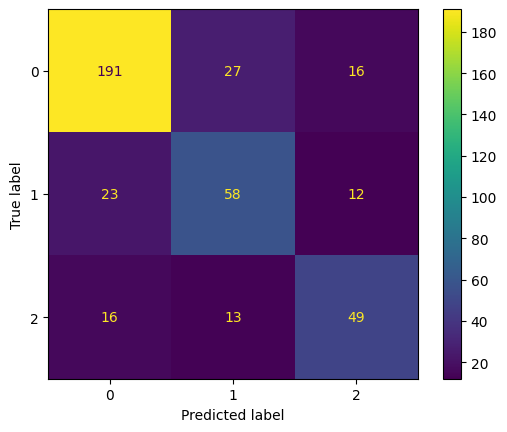

***********************************************

Classifier: Multinomial_NB
              precision    recall  f1-score  support
0              0.782123  0.598291  0.677966    234.0
1              0.459677  0.612903  0.525346     93.0
2              0.450980  0.589744  0.511111     78.0
accuracy       0.600000  0.600000  0.600000      0.6
macro avg      0.564260  0.600312  0.571474    405.0
weighted avg   0.644304  0.600000  0.610785    405.0


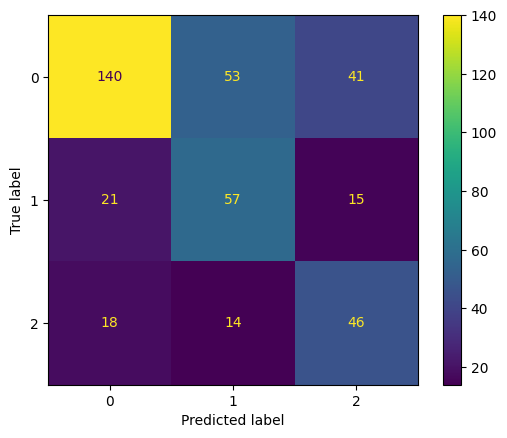

***********************************************

Classifier: KNN
              precision    recall  f1-score     support
0              0.671096  0.863248  0.755140  234.000000
1              0.614035  0.376344  0.466667   93.000000
2              0.425532  0.256410  0.320000   78.000000
accuracy       0.634568  0.634568  0.634568    0.634568
macro avg      0.570221  0.498667  0.513936  405.000000
weighted avg   0.610699  0.634568  0.605093  405.000000


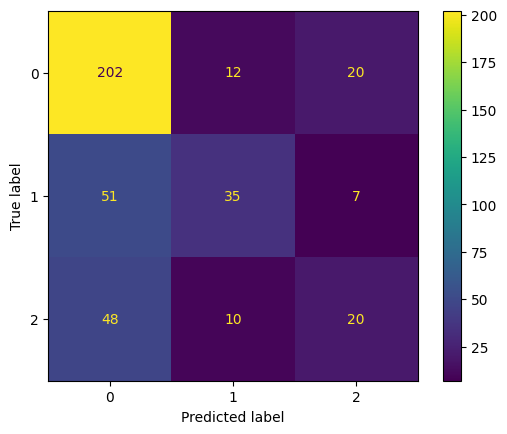

***********************************************

Classifier: Random_Forest
              precision    recall  f1-score     support
0              0.733766  0.965812  0.833948  234.000000
1              0.792453  0.451613  0.575342   93.000000
2              0.840909  0.474359  0.606557   78.000000
accuracy       0.753086  0.753086  0.753086    0.753086
macro avg      0.789043  0.630595  0.671949  405.000000
weighted avg   0.767877  0.753086  0.730771  405.000000


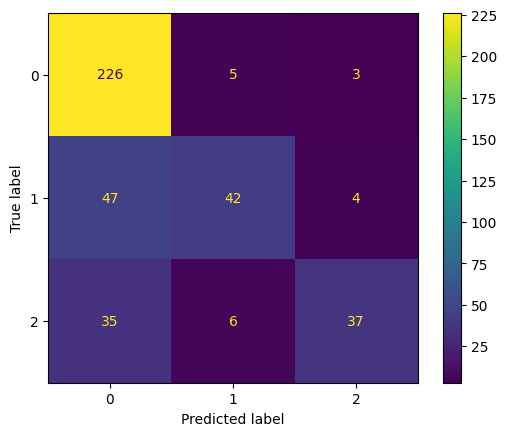

***********************************************

Classifier: Decision_Tree
              precision    recall  f1-score     support
0              0.757202  0.786325  0.771488  234.000000
1              0.534884  0.494624  0.513966   93.000000
2              0.565789  0.551282  0.558442   78.000000
accuracy       0.674074  0.674074  0.674074    0.674074
macro avg      0.619292  0.610743  0.614632  405.000000
weighted avg   0.669286  0.674074  0.671323  405.000000


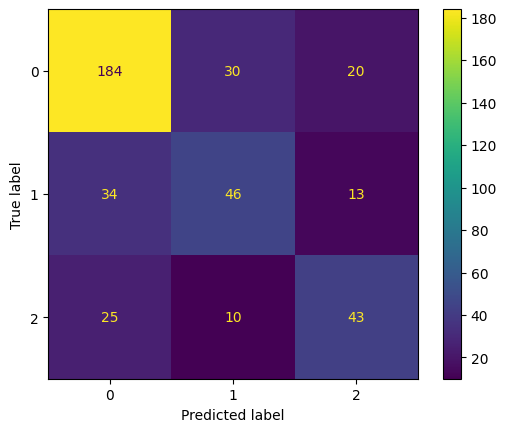

***********************************************

Classifier: Extra_Tree
              precision    recall  f1-score     support
0              0.747508  0.961538  0.841121  234.000000
1              0.813559  0.516129  0.631579   93.000000
2              0.822222  0.474359  0.601626   78.000000
accuracy       0.765432  0.765432  0.765432    0.765432
macro avg      0.794430  0.650675  0.691442  405.000000
weighted avg   0.777065  0.765432  0.746879  405.000000


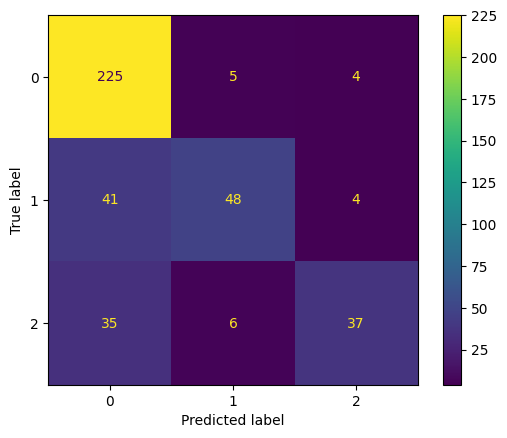

***********************************************

Classifier: Cat_Boost
Learning rate set to 0.084008
0:	learn: 1.0604179	total: 116ms	remaining: 1m 55s
1:	learn: 1.0271487	total: 182ms	remaining: 1m 30s
2:	learn: 1.0020174	total: 238ms	remaining: 1m 19s
3:	learn: 0.9720354	total: 297ms	remaining: 1m 13s
4:	learn: 0.9499263	total: 360ms	remaining: 1m 11s
5:	learn: 0.9277159	total: 431ms	remaining: 1m 11s
6:	learn: 0.9060097	total: 490ms	remaining: 1m 9s
7:	learn: 0.8889538	total: 552ms	remaining: 1m 8s
8:	learn: 0.8745048	total: 612ms	remaining: 1m 7s
9:	learn: 0.8609293	total: 678ms	remaining: 1m 7s
10:	learn: 0.8476625	total: 739ms	remaining: 1m 6s
11:	learn: 0.8342221	total: 798ms	remaining: 1m 5s
12:	learn: 0.8242785	total: 857ms	remaining: 1m 5s
13:	learn: 0.8150775	total: 920ms	remaining: 1m 4s
14:	learn: 0.8084939	total: 989ms	remaining: 1m 4s
15:	learn: 0.8023001	total: 1.05s	remaining: 1m 4s
16:	learn: 0.7950006	total: 1.11s	remaining: 1m 4s
17:	learn: 0.7882632	total: 1.17s	re

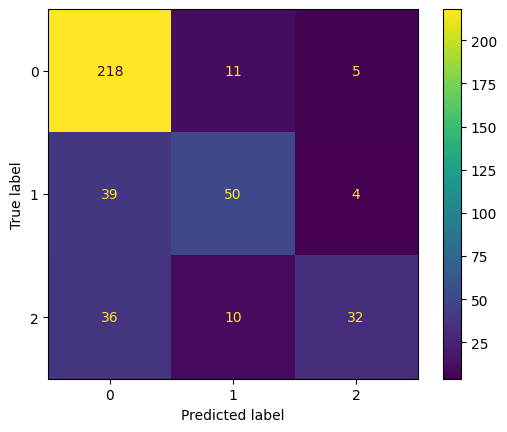

***********************************************

Classifier: Light_GBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5956
[LightGBM] [Info] Number of data points in the train set: 3234, number of used features: 1742
[LightGBM] [Info] Start training from score -0.500775
[LightGBM] [Info] Start training from score -1.563804
[LightGBM] [Info] Start training from score -1.689558
              precision    recall  f1-score     support
0              0.816092  0.910256  0.860606  234.000000
1              0.746667  0.602151  0.666667   93.000000
2              0.695652  0.615385  0.653061   78.000000
accuracy       0.782716  0.782716  0.782716    0.782716
macro avg      0.752804  0.709264  0.726778  405.000000
weighted avg   0.776954  0.782716  0.776100  405.000000


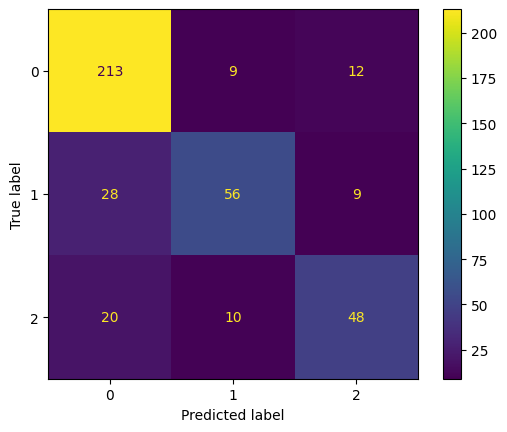

***********************************************

Classifier: MLP
              precision    recall  f1-score     support
0              0.821862  0.867521  0.844075  234.000000
1              0.684783  0.677419  0.681081   93.000000
2              0.636364  0.538462  0.583333   78.000000
accuracy       0.760494  0.760494  0.760494    0.760494
macro avg      0.714336  0.694467  0.702830  405.000000
weighted avg   0.754659  0.760494  0.756430  405.000000


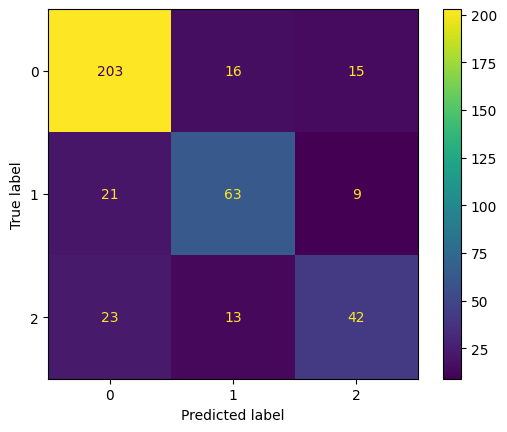

***********************************************

Classifier: SVM
              precision    recall  f1-score     support
0              0.685535  0.931624  0.789855  234.000000
1              0.661017  0.419355  0.513158   93.000000
2              0.821429  0.294872  0.433962   78.000000
accuracy       0.691358  0.691358  0.691358    0.691358
macro avg      0.722660  0.548617  0.578992  405.000000
weighted avg   0.706077  0.691358  0.657775  405.000000


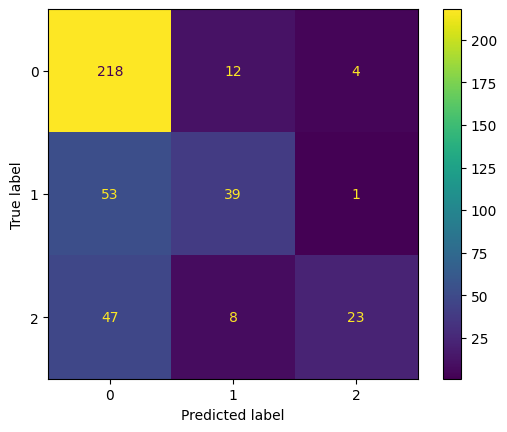

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

for classifier_name, classifier in classifiers.items():
  print('***********************************************')
  print(f'\nClassifier: {classifier_name}')

  classifier.fit(X_train, train_labels)

  y_pred = classifier.predict(X_test)

  report = classification_report(test_labels, y_pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  df.to_csv(f'{vectorizer_option}_{classifier_name}.csv')
  print(df)

  ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

  plt.show()
